In [37]:
import verde as vd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm

import cartopy as ccrs

In [9]:
fp = 'Data/Zim-grav.XYZ'

##cols in file:
##0: Longitude, 1: Latitude, 2:Raw gravity data, 3: Bouguer anomaly

data = np.genfromtxt(fp)
df = pd.DataFrame(data[:,[0,1,3]], columns=['longitude', 'latitude', 'bouguer'])

In [10]:
df.head()

,longitude,latitude,bouguer
0,28.6113,-20.1466,-103.91
1,28.4679,-20.2580,-101.08
2,28.3957,-20.3210,-112.84
3,28.3215,-20.3785,-118.45
4,28.2731,-20.4313,-115.97


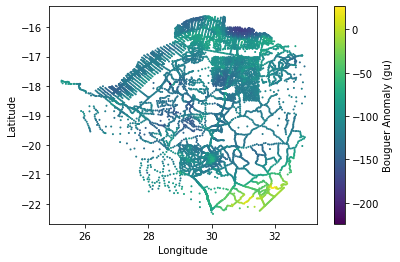

In [21]:
fig, ax = plt.subplots()
points = ax.scatter(df.longitude, df.latitude, c=df.bouguer, s=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.colorbar(points, label='Bouguer Anomaly (gu)')

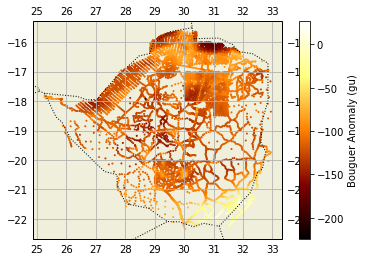

In [34]:
cmap = plt.cm.afmhot

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.crs.PlateCarree()})
points = ax.scatter(df.longitude, df.latitude, c=df.bouguer, s=1, cmap=cmap)
ax.add_feature(ccrs.feature.BORDERS, linestyle=':')
ax.add_feature(ccrs.feature.LAND)
ax.gridlines(draw_labels=True)
fig.colorbar(points, label='Bouguer Anomaly (gu)')

In [39]:
long = df.longitude.to_numpy()
lat = df.latitude.to_numpy()
bouguer = df.bouguer.to_numpy()

In [40]:
utm.from_latlon(lat, long)

(array([668410.86372589, 653311.13029841, 645710.29508834, ...,
        835476.34654881, 698170.14453218, 933445.47848651]),
 array([7771480.03313342, 7759287.89627348, 7752379.77600228, ...,
        8103675.620455  , 7910474.67363748, 7958826.54201226]),
 35,
 'K')

In [41]:
#Convert latlong to UTM
east = utm.from_latlon(lat, long)[0]
north = utm.from_latlon(lat, long)[1]

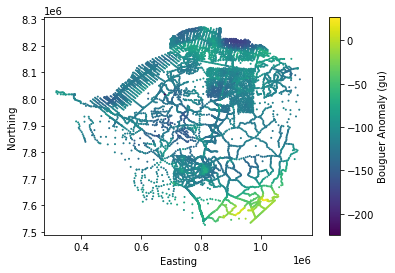

In [43]:
fig, ax = plt.subplots()
points = ax.scatter(east, north, c=bouguer, s=1)
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
fig.colorbar(points, label='Bouguer Anomaly (gu)')

In [118]:
nx = 512
ny = 512
sqsize = 100e3 ## Size of squares in metres
emin = 810e3 ## Easting in SW corner
emax = emin + sqsize
nmin = 8000e3   ## Northing in SW corner
nmax = nmin + sqsize

W, E, S, N = emin, emax, nmin, nmax
region = (W, E, S, N)

In [122]:
grd = vd.ScipyGridder(method='linear').fit((east, north), bouguer)

In [123]:
grid = grd.grid(region = region, shape=(nx, ny), data_names='Gravity (gu)')

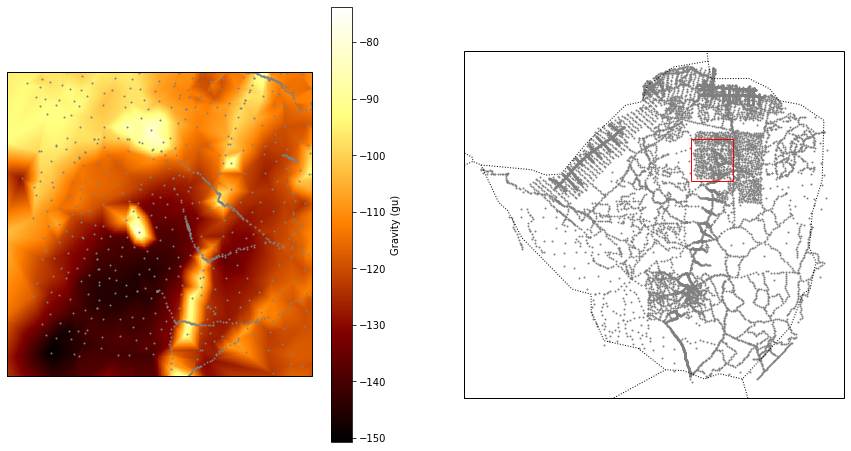

In [132]:
import matplotlib.patches as patches

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8), subplot_kw={'projection': ccrs.crs.UTM(zone=35, southern_hemisphere=True)})
grid['Gravity (gu)'].plot.pcolormesh(ax=ax1, cmap=cmap)
ax1.scatter(east, north, s=1, color='grey')
ax1.set_xlim(W, E)
ax1.set_ylim(S, N)
ax1.set_aspect('equal')

ax2.scatter(east, north, s=1, color='grey')
ax2.add_patch(patches.Rectangle(xy=(W, S), width=sqsize, height=sqsize, edgecolor='red', facecolor='none'))
ax2.set_aspect('equal')
ax2.add_feature(ccrs.feature.BORDERS, linestyle=':')
#ax2.set_xlim(W, E)
#ax2.set_ylim(S, N)

In [142]:
#Repeat for different grid
nx = 512
ny = 512
sqsize = 120e3 ## Size of squares in metres
emin = 700e3 ## Easting in SW corner
emax = emin + sqsize
nmin = 7660e3   ## Northing in SW corner
nmax = nmin + sqsize

W, E, S, N = emin, emax, nmin, nmax
region = (W, E, S, N)

grd = vd.ScipyGridder(method='linear').fit((east, north), bouguer)

grid2 = grd.grid(region = region, shape=(nx, ny), data_names='Gravity (gu)')

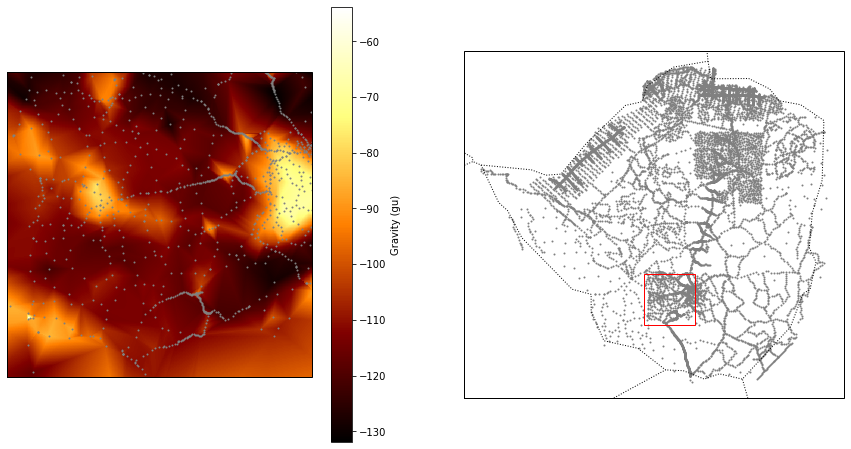

In [143]:
import matplotlib.patches as patches

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8), subplot_kw={'projection': ccrs.crs.UTM(zone=35, southern_hemisphere=True)})
grid2['Gravity (gu)'].plot.pcolormesh(ax=ax1, cmap=cmap)
ax1.scatter(east, north, s=1, color='grey')
ax1.set_xlim(W, E)
ax1.set_ylim(S, N)
ax1.set_aspect('equal')

ax2.scatter(east, north, s=1, color='grey')
ax2.add_patch(patches.Rectangle(xy=(W, S), width=sqsize, height=sqsize, edgecolor='red', facecolor='none'))
ax2.set_aspect('equal')
ax2.add_feature(ccrs.feature.BORDERS, linestyle=':')
#ax2.set_xlim(W, E)
#ax2.set_ylim(S, N)

#### Magnetic Data!

In [162]:
fp = './Data/Plutons-mag.xyz'
## cols in file:
## 0: Northing (m), 1: Easting (m), Magnetic field (nT)
dat = np.genfromtxt(fp)

## Distributing data into relevant arrays
east = dat[:,0]
north = dat[:,1]
mag = dat[:,2]

erange = np.max(east)-np.min(east)
nrange = np.max(north)-np.min(north)

box_range = np.min((erange,nrange))

#Filter out of range numbers
isbad = mag <-5e10
mag[isbad]=0

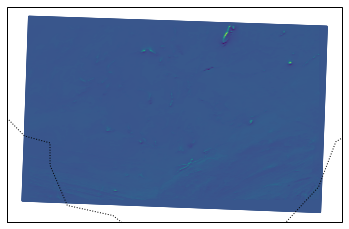

In [163]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.crs.UTM(35, southern_hemisphere=True)})
ax.scatter(east, north, transform=ccrs.crs.epsg(20936), s=1, c=mag)
ax.add_feature(ccrs.feature.BORDERS, linestyle=':')

In [164]:
##### Preparing the data for ffts by creating equally spaced square grid #####
nx = 2**8
ny = 2**8
sqsize = box_range ## Size of squares in metres
emin = np.max(east)-sqsize ## Easting in SW corner
emax = np.max(east)
nmin = np.max(north)-sqsize  ## Northing in SW corner
nmax = np.max(north)

region = (emin, emax, nmin, nmax)

In [165]:
grid = vd.ScipyGridder(method='cubic').fit((east, north), mag).grid(region = region, shape=(nx, ny), data_names='mag')

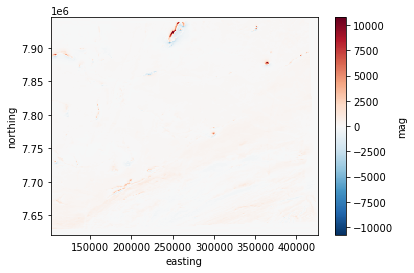

In [170]:
grid.mag.plot.pcolormesh()

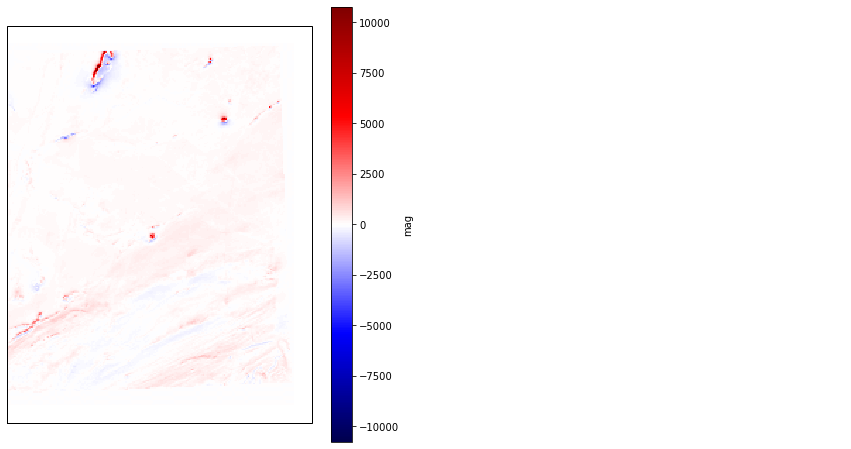

In [176]:
import matplotlib.patches as patches

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8), subplot_kw={'projection': ccrs.crs.epsg(20936)})
grid.mag.plot.pcolormesh(ax=ax1, cmap='seismic')
#ax1.scatter(east, north, s=1, color='grey')
#ax1.set_xlim(W, E)
#ax1.set_ylim(S, N)
ax1.set_aspect('equal')

#ax2.scatter(east, north, s=1, color='grey')
ax2.add_patch(patches.Rectangle(xy=(emin, nmin), width=sqsize, height=sqsize, edgecolor='red', facecolor='none'))
ax2.set_aspect('equal')
#ax2.add_feature(ccrs.feature.BORDERS, linestyle=':')
#ax2.set_xlim(W, E)
#ax2.set_ylim(S, N)